In [2]:
#Create a train/test split for zipcode level NY housing price prediction
import os
import pickle
load_dir='/afs/cs.stanford.edu/u/tgebru/cvpr2016/housing_data/'

with open(os.path.join(load_dir,'ny_housing_dict.pickle'),'rb') as f:
    ny_housing_dict=pickle.load(f)

with open(os.path.join(load_dir,'housing_dict.pickle'),'rb') as f:
    housing_dict=pickle.load(f)

with open(os.path.join(load_dir,'zipcode_dict.pickle'),'rb') as f:
    zipcode_dict=pickle.load(f)                     
    
with open('lat_lng_rot_date_dict.pickle','rb') as f:
    lat_lng_rot_date_dict=pickle.load(f)  
    
with open('zipcode_pairs_dict.pickle','rb') as f:
    zipcode_pairs_dict=pickle.load(f)  

with open('lat_lng_rot_pairs_dict.pickle','rb') as f:
    lat_lng_rot_pairs_dict=pickle.load(f)

with open('lat_lng_rot_date_file_dict.pickle','rb') as f:
    lat_lng_rot_date_file_dict=pickle.load(f)
    

In [3]:
#Create a dictionary with all necessary info for housing
housing_prices=[]
norm_housing_prices=[]
lat_lng_rot_zip_date_price={}

for key in lat_lng_rot_date_dict.keys():
    dates=lat_lng_rot_date_dict[key]
    zipcode=str(zipcode_dict['%s_%s'%(key.split('_')[0],key.split('_')[1])])
    if zipcode in housing_dict:
        prices=[]
        norm_prices=[]
        for d in dates:
           if d in housing_dict[zipcode]:
             price=housing_dict[zipcode][d]
             if price:
                 norm_price=float(price)/float(ny_housing_dict[d])
             else:
                price=-1
                norm_price=-1
           else:
             price=-1
             norm_price=-1
           prices.append(price)
           norm_prices.append(norm_price)
    else:
        prices=[]
        norm_prices=[]
    lat_lng_rot_zip_date_price[key]={}
    lat_lng_rot_zip_date_price[key]['zip']=zipcode
    lat_lng_rot_zip_date_price[key]['dates']=dates
    lat_lng_rot_zip_date_price[key]['prices']=prices
    lat_lng_rot_zip_date_price[key]['norm_prices']=norm_prices
    housing_prices.extend(prices)
    norm_housing_prices.extend(norm_prices)

with open('lat_lng_rot_zip_date_price.pickle','wb') as f:
    pickle.dump(lat_lng_rot_zip_date_price,f)

In [4]:
with open('lat_lng_rot_zip_date_price.pickle','rb') as f:
    lat_lng_rot_zip_date_price=pickle.load(f)

In [19]:
#Create train/test split for housing using one date (2013)
#Divide housing prices into 4 bins
import numpy as np
import math
import sets

MIN_PAIRS=100
zipcodes=zipcode_pairs_dict.keys()
pairs=[int(zipcode_pairs_dict[z]) for z in zipcodes]
filtered_pair_inds=np.where(np.array(pairs)>MIN_PAIRS)
filtered_zipcodes=[zipcodes[i] for i in filtered_pair_inds[0] if zipcodes[i] !='None']

#first count how many total image,price pairs are in 2013
#Make a new dict with only 2013

#Year of choice for classification 
chosen_year='2013' #has the most number of images after 2007
#chosen_year=''

lat_lng_rot_zip_2013_price={}
zipcodes_2013=[]
prices_2013=[]
norm_prices_2013=[]

for key in lat_lng_rot_zip_date_price.keys():
    zipcode=lat_lng_rot_zip_date_price[key]['zip']
    for date,price,norm_price in zip(lat_lng_rot_zip_date_price[key]['dates'],
                                    lat_lng_rot_zip_date_price[key]['prices'],
                                    lat_lng_rot_zip_date_price[key]['norm_prices']):
        if chosen_year:
            if date.split('-')[-1].strip()!=chosen_year:continue
        if price !=-1 and zip !='None' and norm_price !=-1:
            lat_lng_rot_zip_2013_price[key]={}
            lat_lng_rot_zip_2013_price[key]['zip']=zipcode
            lat_lng_rot_zip_2013_price[key]['date']=date
            lat_lng_rot_zip_2013_price[key]['price']=price
            lat_lng_rot_zip_2013_price[key]['norm_price']=norm_price
            zipcodes_2013.append(zipcode)
            prices_2013.append(price)
            norm_prices_2013.append(norm_price)
            
prices_2013_float=np.array([float(p) for p in prices_2013])
norm_prices_2013_float=np.array([float(p) for p in norm_prices_2013])

LOW=np.percentile(prices_2013_float,25)
MEDIUM_LOW=np.percentile(prices_2013_float,50)
MEDIUM_HIGH=np.percentile(prices_2013_float,75)

LOW_NORM=np.percentile(norm_prices_2013_float,25)
MEDIUM_LOW_NORM=np.percentile(norm_prices_2013_float,50)
MEDIUM_HIGH_NORM=np.percentile(norm_prices_2013_float,75)
            
#Create random permutation of zipcodes in 2013
zipcodes_2013=list(set(zipcodes_2013))
filtered_2013=[z for z in zipcodes_2013 if z in filtered_zipcodes]
rand_filtered_zipcodes=np.random.permutation(filtered_2013)

#Create train/val/test zipcodes
TRAIN_FRAC=0.45
TEST_FRAC=0.45
VAL_FRAC=0.1 

num_ims=len(lat_lng_rot_zip_2013_price.keys())
    
#Divide zipcodes to train/val/test
#Get number of images per zipcode
zipcode_ims={}
for key in lat_lng_rot_zip_2013_price.keys():
  zipcode=lat_lng_rot_zip_2013_price[key]['zip']
  if zipcode in filtered_2013:
        if zipcode in zipcode_ims:
            zipcode_ims[zipcode] += 1
        else:
            zipcode_ims[zipcode] = 1
num_train=0
num_test=0
num_val=0
train_zips=set()
test_zips=set()
val_zips=set()
for z in rand_filtered_zipcodes:
    if num_train < TRAIN_FRAC*num_ims:
        num_train += zipcode_ims[z]
        train_zips.add(z)
    elif num_test <TEST_FRAC*num_ims:
        num_test += zipcode_ims[z]
        test_zips.add(z) 
    elif num_val <VAL_FRAC*num_ims:
        num_val += zipcode_ims[z]
        val_zips.add(z)

print train_zips.intersection(test_zips)
print train_zips.intersection(val_zips)
print val_zips.intersection(train_zips)
print len(train_zips),num_train,TRAIN_FRAC*num_ims
print len(test_zips),num_test,TEST_FRAC*num_ims
print len(val_zips),num_val,VAL_FRAC*num_ims
print num_train+num_test+num_val,num_ims
print len(filtered_2013), len(train_zips)+len(test_zips)+len(val_zips)

set([])
set([])
set([])
36 18330 18158.85
28 18322 18158.85
10 3501 4035.3
40153 40353
74 74


In [20]:
print -1 in list(set(prices_2013))
print len(lat_lng_rot_zip_date_price.keys()),num_ims

False
72864 40353


In [21]:
#train/val/test tuples (lat_lng_date,label)
#class=classification (into 4 bins)
#Reg=regression, norm=normalized by overall NY price
train_class_list=[]
val_class_list=[]
test_class_list=[]

norm_train_class_list=[]
norm_val_class_list=[]
norm_test_class_list=[]

train_reg_list=[]
val_reg_list=[]
test_reg_list=[]

norm_train_reg_list=[]
norm_val_reg_list=[]
norm_test_reg_list=[]

num_train=0
num_test=0
num_val=0

for key in lat_lng_rot_zip_2013_price:
        price=float(lat_lng_rot_zip_2013_price[key]['price'])
        norm_price=float(lat_lng_rot_zip_2013_price[key]['norm_price'])
        if price<=LOW:
            class_val=0
        elif price>LOW and price <=MEDIUM_LOW:
            class_val=1
        elif price>MEDIUM_LOW and price<=MEDIUM_HIGH:
            class_val=2
        else:
            class_val=3
        if norm_price<=LOW_NORM:
            norm_class_val=0
        elif norm_price>LOW_NORM and norm_price <=MEDIUM_LOW_NORM:
            norm_class_val=1
        elif norm_price>MEDIUM_LOW_NORM and norm_price<=MEDIUM_HIGH_NORM:
            norm_class_val=2
        else:
            norm_class_val=3
        zipcode=lat_lng_rot_zip_2013_price[key]['zip']
        date=lat_lng_rot_zip_2013_price[key]['date']
        if zipcode in rand_filtered_zipcodes:
            #test
            if zipcode in test_zips and num_test<num_ims*TEST_FRAC :
               test_reg_list.append((key,date,price))
               norm_test_reg_list.append((key,date,norm_price))
               test_class_list.append((key,date,class_val))
               norm_test_class_list.append((key,date,norm_class_val))
               num_test += 1
            #train 
            elif zipcode in train_zips and num_train<num_ims*TRAIN_FRAC:
                lat_lng_rot_zip_2013_price[key]['zip'] 
                train_reg_list.append((key,date,price))
                norm_train_reg_list.append((key,date,norm_price))
                train_class_list.append((key,date,class_val))
                norm_train_class_list.append((key,date,norm_class_val))   
                num_train += 1
            #val
            elif zipcode in val_zips and num_val<num_ims*VAL_FRAC:
                val_reg_list.append((key,date,price))
                norm_val_reg_list.append((key,date,norm_price))
                val_class_list.append((key,date,class_val))
                norm_val_class_list.append((key,date,norm_class_val))  
                num_val += 1
print num_train,num_test,num_val
print TRAIN_FRAC*num_ims, TEST_FRAC*num_ims,VAL_FRAC*num_ims

18159 18159 3501
18158.85 18158.85 4035.3


In [22]:
#Randomly Permulte train,val,test sets
train_reg_list=np.random.permutation(train_reg_list)
norm_train_reg_list=np.random.permutation(norm_train_reg_list)
train_class_list=np.random.permutation(train_class_list)
norm_train_class_list=np.random.permutation(norm_train_class_list)
test_reg_list=np.random.permutation(test_reg_list)
norm_test_reg_list=np.random.permutation(norm_test_reg_list)
test_class_list=np.random.permutation(test_class_list)
norm_test_class_list=np.random.permutation(norm_test_class_list)
val_reg_list=np.random.permutation(val_reg_list)
norm_val_reg_list=np.random.permutation(norm_val_reg_list)
val_class_list=np.random.permutation(val_class_list)
norm_val_class_list=np.random.permutation(norm_val_class_list)

In [23]:
#Helper function to get images from lat,lng,rot,date 
def lat_lng_to_path(lat,lng,rot,date):
  '''Converts latitude and longitude into a folder to save images in.'''
  base_dir='/imagenetdb3/data/geo/gsv_time_fixed_unwarp/'
  lat_base = lat.split('.')[0]
  lng_base = lng.split('.')[0]
  subfolder1 = '%s_%s' % (lat_base, lng_base)
  lat_dec = lat.split('.')[1]
  lng_dec = lng.split('.')[1]
  subfolder2 = '%s_%s' % (lat_dec[0], lng_dec[0])
  subfolder3 = '%s_%s' % (lat_dec[1], lng_dec[1])
  subfolder4 = '%s_%s' % (lat_dec[2], lng_dec[2])
  pitch=0
  im_name = '%s_%s_%s_%s.jpg'%(lat, lng, rot,date)
  return os.path.join(base_dir, subfolder1, subfolder2, subfolder3, subfolder4,im_name)

In [24]:
def write_to_file(fname,data_list):
    f=open(fname,'wb')
    for d in data_list:
        im=lat_lng_rot_date_file_dict['%s_%s_%s_%s'%(
                           d[0].split('_')[0],
                           d[0].split('_')[1],
                           d[0].split('_')[2],
                           d[1])]
        class_val=d[2]
        f.write('%s %s\n'%(im[1:],class_val)) #remove leading / from im name
    f.close()

In [25]:
if chosen_year:
    year=chosen_year
else:
    year='all'

#Create text file with train/val/test housing data
output_data_root='/scr/r6/tgebru/timnit_caffe/data/ny_housing'

#train
train_reg_file=os.path.join(output_data_root,
                               'housing_%s_reg_train.txt'%(year))
train_reg_norm_file=os.path.join(output_data_root,
                               'housing_%s_reg_norm_train.txt'%(year))
train_class_file=os.path.join(output_data_root,
                               'housing_%s_class_train.txt'%(year))
train_class_norm_file=os.path.join(output_data_root,
                               'housing_%s_class_norm_train.txt'%(year))

#Test
test_reg_file=os.path.join(output_data_root,
                               'housing_%s_reg_test.txt'%(year))
test_reg_norm_file=os.path.join(output_data_root,
                               'housing_%s_reg_norm_test.txt'%(year))
test_class_file=os.path.join(output_data_root,
                               'housing_%s_class_test.txt'%(year))
test_class_norm_file=os.path.join(output_data_root,
                               'housing_%s_class_norm_test.txt'%(year))

#Val
val_reg_file=os.path.join(output_data_root,
                               'housing_%s_reg_val.txt'%(year))
val_reg_norm_file=os.path.join(output_data_root,
                               'housing_%s_reg_norm_val.txt'%(year))
val_class_file=os.path.join(output_data_root,
                               'housing_%s_class_val.txt'%(year))
val_class_norm_file=os.path.join(output_data_root,
                               'housing_%s_class_norm_val.txt'%(year))

output_data=[
    (train_reg_file,train_reg_list),
    (train_reg_norm_file,norm_train_reg_list),
    (train_class_file,train_class_list),
    (train_class_norm_file,norm_train_class_list), 
    (test_reg_file,test_reg_list),
    (test_reg_norm_file,norm_test_reg_list),
    (test_class_file,test_class_list),
    (test_class_norm_file,norm_test_class_list),
    (val_reg_file,val_reg_list),
    (val_reg_norm_file,norm_val_reg_list),
    (val_class_file,val_class_list),
    (val_class_norm_file,norm_val_class_list)
]

for d in output_data:
    write_to_file(d[0],d[1])

In [33]:
print LOW, MEDIUM_LOW, MEDIUM_HIGH
print prices_2013_float.min(), prices_2013_float.max()

375000.0 415000.0 529000.0
249000.0 3700000.0


In [50]:
#Plot histogram of classes
def plot_hist(arr,num_classes,ylabel,xlabel):
    fig,ax=plt.subplots()
    n,bins,patches=plt.hist(arr,num_classes,normed=0,facecolor='g',alpha=0.75)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(np.arange(num_classes), np.arange(num_classes), 
     rotation='horizontal')
    plt.show()



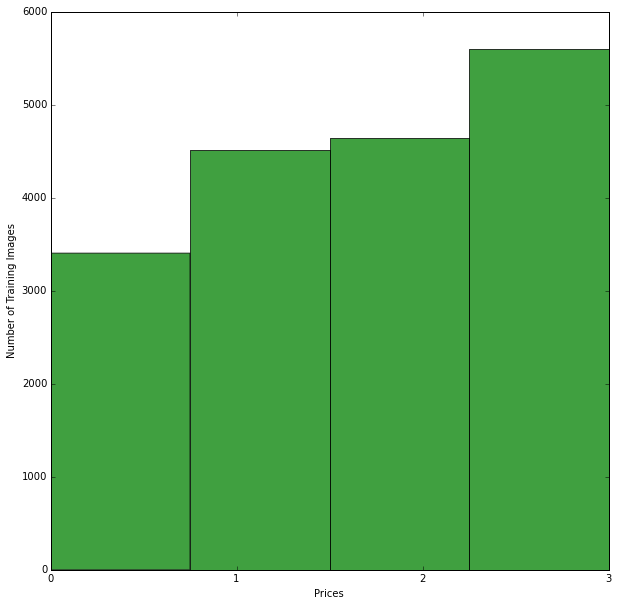

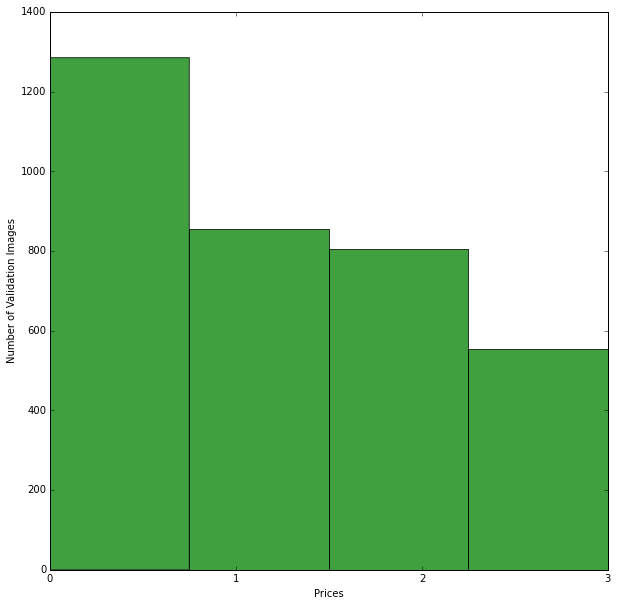

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(10,10)

train_prices=[int(t[-1]) for t in train_class_list]
val_prices=[int(v[-1]) for v in val_class_list]
plot_hist(train_prices,4,'Number of Training Images','Prices')
plot_hist(val_prices,4,'Number of Validation Images','Prices')

